In [31]:
import pandas as pd
import numpy as np
import spacy
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

In [4]:
df = pd.read_csv('tripadvisor_emirates_reviews.csv', index_col=0)
df.head()

,_id,title,text,rating,reviewer_handle,language,airline_name,flight_date,flight_connection,flight_type,booking_class
0,BAFHFJ4n,NaN,Ich bin sehr positiv angetan mit diese Gesells...,5.0,NaN,NaN,Emirates,NaN,NaN,NaN,NaN
1,DKCtYZuj,NaN,Flug war auf der Hinreise knapp 1 Stunde versp...,3.0,NaN,NaN,Emirates,NaN,NaN,NaN,NaN
2,gUyMgdC3,NaN,Flug wurde von Sbg ursprünglich gebucht. Wurde...,2.0,NaN,NaN,Emirates,NaN,NaN,NaN,NaN
3,MHjJQCeQ,NaN,Wir sind um 15 Uhr 30 in den Flieger gestiegen...,2.0,NaN,NaN,Emirates,NaN,NaN,NaN,NaN
4,ppb5iYWW,NaN,"Flug war auf der Hinreise 2h verspätet, auf de...",3.0,NaN,NaN,Emirates,NaN,NaN,NaN,NaN


In [7]:
# Initialize german language model
##download and install the model
##pip install spacy
##pip install -U pip setuptools wheel
##pip install -U spacy
##python -m spacy download en_core_web_sm
nlp = spacy.load("de_core_news_sm")

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 990 entries, 0 to 989
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   _id                990 non-null    object 
 1   title              0 non-null      float64
 2   text               990 non-null    object 
 3   rating             990 non-null    float64
 4   reviewer_handle    0 non-null      float64
 5   language           0 non-null      float64
 6   airline_name       990 non-null    object 
 7   flight_date        0 non-null      float64
 8   flight_connection  0 non-null      float64
 9   flight_type        0 non-null      float64
 10  booking_class      0 non-null      float64
dtypes: float64(8), object(3)
memory usage: 92.8+ KB


In [10]:
df[df['rating'] == 5.0]

,_id,title,text,rating,reviewer_handle,language,airline_name,flight_date,flight_connection,flight_type,booking_class
0,BAFHFJ4n,NaN,Ich bin sehr positiv angetan mit diese Gesells...,5.0,NaN,NaN,Emirates,NaN,NaN,NaN,NaN
8,4NsVzOzj,NaN,"Urlaubsreise zu den Seychellen, waren mit Emir...",5.0,NaN,NaN,Emirates,NaN,NaN,NaN,NaN
9,to6o8fRs,NaN,"Toller Service, freundliches Personal und Esse...",5.0,NaN,NaN,Emirates,NaN,NaN,NaN,NaN
13,3Qrk5J5f,NaN,Es war unser erster Flug mit Emirates und nach...,5.0,NaN,NaN,Emirates,NaN,NaN,NaN,NaN
19,mIGkL27s,NaN,Wir sind von Dubai nach Zürich geflogen.\nWir ...,5.0,NaN,NaN,Emirates,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
981,Zdb34t4Q,NaN,Was soll man zu Emirates sagen. Sitzkomfort to...,5.0,NaN,NaN,Emirates,NaN,NaN,NaN,NaN
982,2ilQRe0x,NaN,Die Business-Klasse ist wie immer sehr solide ...,5.0,NaN,NaN,Emirates,NaN,NaN,NaN,NaN
983,reiyCHYN,NaN,"Das erste mal mit Emirates. Alles reibungslos,...",5.0,NaN,NaN,Emirates,NaN,NaN,NaN,NaN
988,W0j7Bl6L,NaN,Zwischenstopp in Dubai alles perfekt geklappt ...,5.0,NaN,NaN,Emirates,NaN,NaN,NaN,NaN


In [11]:
# Add sentiment label pos, neu, neg
def categorize(rating):

    if rating >= 4.0:
        return 'positive'
    elif rating == 3.0:
        return 'neutral'
    else:
        return 'negative'

<AxesSubplot: >

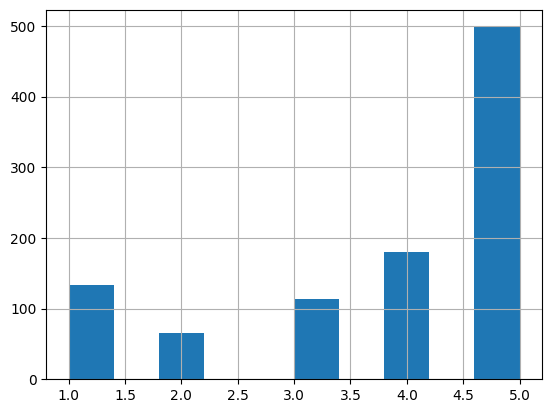

In [9]:
# Rating Distribution
df['rating'].hist()

In [12]:
df['sentiment'] = df['rating'].apply(categorize)

<AxesSubplot: >

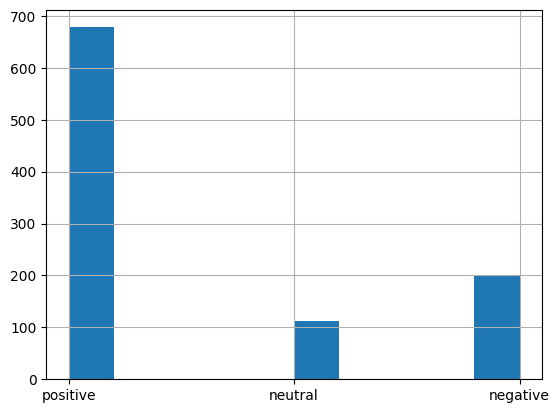

In [13]:
df['sentiment'].hist()

In [14]:
# Sentiment to target number
target_map = {'positive':1, 'negative':0, 'neutral':2}
df['target'] = df['sentiment'].map(target_map)

In [17]:
# Preprocessing

def lower(review):
    return review.lower()

def remove_stopwords(review):
    
    doc = nlp(review)
    filtered_tokens = [token.text for token in doc if not token.is_stop]
    review = ' '.join(filtered_tokens)
    
    return review

def remove_punct(review):
    
    pattern = r'[^a-zA-ZäöüÄÖÜß\s]'
    review = re.sub(pattern, '', review)
    return review

def remove_trailing_newlines(review):

    pattern = r'\n+$'
    review = re.sub(pattern, '', review)
    return review

def lemmatize(review):
    
    doc = nlp(review)
    lemmatized_tokens = [token.lemma_ for token in doc]
    lemmatized_text = ' '.join(lemmatized_tokens)
    
    return lemmatized_text

def replace_spaces(review):
    review = re.sub(r'\s+', ' ', review)
    return review
    

In [18]:
# Preprocessing

df['text'] = df['text'].apply(lower)
df['text'] = df['text'].apply(remove_stopwords)
df['text'] = df['text'].apply(remove_punct)
df['text'] = df['text'].apply(remove_trailing_newlines)
df['text'] = df['text'].apply(lemmatize)
df['text'] = df['text'].apply(replace_spaces)

In [19]:
df.head()

,_id,title,text,rating,reviewer_handle,language,airline_name,flight_date,flight_connection,flight_type,booking_class,sentiment,target
0,BAFHFJ4n,NaN,positiv antun Gesellschaft fliegen sogar mal m...,5.0,NaN,NaN,Emirates,NaN,NaN,NaN,NaN,positive,1
1,DKCtYZuj,NaN,Flug Hinreise knapp Stunde verspätet Hinweis w...,3.0,NaN,NaN,Emirates,NaN,NaN,NaN,NaN,neutral,2
2,gUyMgdC3,NaN,Flug sbg ursprünglich buchen seitens emirat St...,2.0,NaN,NaN,Emirates,NaN,NaN,NaN,NaN,negative,0
3,MHjJQCeQ,NaN,Flieger steigen Stunde mal trinken essen serv...,2.0,NaN,NaN,Emirates,NaN,NaN,NaN,NaN,negative,0
4,ppb5iYWW,NaN,Flug Hinreise h verspäten Rückreise Minute gen...,3.0,NaN,NaN,Emirates,NaN,NaN,NaN,NaN,neutral,2


In [21]:
# Training

# Train-Test split
df_train, df_test =train_test_split(df)

In [22]:
df_train.head()

,_id,title,text,rating,reviewer_handle,language,airline_name,flight_date,flight_connection,flight_type,booking_class,sentiment,target
143,cY8c0Fnt,NaN,negativ test dha Dubai health Authority alt St...,1.0,NaN,NaN,Emirates,NaN,NaN,NaN,NaN,negative,0
532,deIvwLY3,NaN,Service Bord Rückflug Dubai Hamburg renommiert...,2.0,NaN,NaN,Emirates,NaN,NaN,NaN,NaN,negative,0
479,i3oBMIvJ,NaN,airlin Hochgelobt erwarten strecke Zürichdubai...,3.0,NaN,NaN,Emirates,NaN,NaN,NaN,NaN,neutral,2
340,b1Q5PYf7,NaN,emirates brauchen Bewertung schreiben Super Es...,5.0,NaN,NaN,Emirates,NaN,NaN,NaN,NaN,positive,1
341,a1yeKWn0,NaN,mal Airbus -- fliegen schön nachtflug Flug her...,5.0,NaN,NaN,Emirates,NaN,NaN,NaN,NaN,positive,1


In [25]:
vectorizer = TfidfVectorizer(max_features=50)

In [26]:
X_train = vectorizer.fit_transform(df_train['text'])

In [27]:
X_train

<742x50 sparse matrix of type '<class 'numpy.float64'>'
	with 3736 stored elements in Compressed Sparse Row format>

In [28]:
X_test = vectorizer.transform(df_test['text'])

In [29]:
Y_train = df_train['target']
Y_test = df_test['target']

In [33]:
model = LogisticRegression(max_iter=500)
model.fit(X_train, Y_train)
print("Train Acc:", model.score(X_train, Y_train))
print("Test Acc:", model.score(X_test, Y_test))

Train Acc: 0.7560646900269542
Test Acc: 0.6693548387096774


In [34]:
Pr_train = model.predict_proba(X_train)
Pr_test = model.predict_proba(X_test)
print("Train AUC-ROC:", roc_auc_score(Y_train, Pr_train, multi_class='ovo'))
print("Test AUC-ROC:", roc_auc_score(Y_test, Pr_test, multi_class='ovo'))

Train AUC-ROC: 0.8118390297610992
Test AUC-ROC: 0.7178848962898042


In [35]:
P_train = model.predict(X_train)
P_test = model.predict(X_test)

In [36]:
cm = confusion_matrix(Y_train, P_train, normalize='true')
cm

array([[0.46979866, 0.53020134, 0.        ],
       [0.04854369, 0.94951456, 0.00194175],
       [0.14102564, 0.83333333, 0.02564103]])